In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### **IMPORTS AND DOWNLOADS**

In [ ]:
!pip install  gast==0.3.3
!pip install grpcio~=1.32.0
!pip install h5py~=2.10.0
!pip install tensorflow-estimator==2.4.0

In [ ]:
!pip install tensorflow-gpu==2.4.0 

In [ ]:
!pip install tqdm  >> /dev/null

In [ ]:
!pip install bert-for-tf2 >> /dev/null

In [ ]:
!pip install sentencepiece >> /dev/null

In [ ]:
!pip install jsonlines

In [ ]:
import os
import math
import datetime
import jsonlines
from tqdm import tqdm

import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import train_test_split



%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

COLORS = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(COLORS))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# **DATASET LOADING**

In [ ]:


def porters_algo(sentence):
  ps = PorterStemmer()
  a=""
  
  w = word_tokenize(sentence)
  for i in w:
    i=ps.stem(i)
    a=a+i+" "
  return a


In [ ]:
stop_words = stopwords.words("english")

In [ ]:
dat = []
val = []
df = pd.read_csv('/content/drive/MyDrive/DATASETS/gab.csv', error_bad_lines=False)
del df["id"]
dataf=pd.DataFrame(df)
dataf

for i in range(len(dataf)):
  if dataf.loc[i,"hate_speech_idx"]=="[1]" or dataf.loc[i,"hate_speech_idx"]=="[2]" :
    dat.append(dataf.loc[i,"text"])
    val.append("1")

for i in range(len(dat)) :
  dat[i]=dat[i].replace("1.","")

with jsonlines.open('/content/drive/MyDrive/DATASETS/Dataset for Detection of Cyber-Trolls.json') as reader:
  for i in range(20000):
    b = reader.read()
    
    dat.append(b['content'])
    val.append(b['annotation']['label'][0])



dict0 = {"Sent":dat,"Label":val}
dataset3 = pd.DataFrame(dict0)

In [ ]:
for j in range(len(dataset3)):
  i=dataset3.loc[j,"Sent"]
  i = i.lower()
  i = word_tokenize(i)
  a = [w for w in i if not w in stop_words and w.isalnum()]
  empty=""
  for x in a :
    empty=empty+" " +x
  final=porters_algo(empty)
  dataset3.loc[j,"Sent"]=final

train, test = train_test_split(dataset3, test_size=0.2, random_state=1000)

In [ ]:
bert_file = "/content/drive/MyDrive/BERT/lightmodel/bert_model.ckpt"
config_file = "/content/drive/MyDrive/BERT/lightmodel/bert_config.json"
token = FullTokenizer(vocab_file="/content/drive/MyDrive/BERT/lightmodel/vocab.txt")


# **TRAINING**

In [ ]:
class hate:
  dat = "Sent"
  label = "Label"

  def __init__(self, train, test, token: FullTokenizer, classes, max_length=192):
    self.token = token
    self.max_length = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self.prep, [train, test])

    print("max seq_len", self.max_length)
    self.max_length = min(self.max_length, max_length)
    self.train_x, self.test_x = map(self.add_padding, [self.train_x, self.test_x])

  def prep(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[hate.dat], row[hate.label]
      tok = self.token.tokenize(text)
      tok = ["[CLS]"] + tok + ["[SEP]"]
      tids = self.token.convert_tokens_to_ids(tok)
      self.max_length = max(self.max_length, len(tids))
      x.append(tids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def add_padding(self, ids):
    x = []
    for inputid in ids:
      inputid = inputid[:min(len(inputid), self.max_length - 2)]
      inputid = inputid + [0] * (self.max_length - len(inputid))
      x.append(np.array(inputid))
    return np.array(x)


In [ ]:
def new_model(max_length, bert_file):

  with tf.io.gfile.GFile(config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_parameters = map_stock_config_to_params(bc)
      bert_parameters.adapter_size = None
      bert = BertModelLayer.from_params(bert_parameters, name="bert")
        
  inputid = keras.layers.Input(shape=(max_length, ), dtype='int32', name="inputid")
  bert_output = bert(inputid)

  print("bert shape", bert_output.shape)

  out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  out = keras.layers.Dropout(0.5)(out)
  logit = keras.layers.Dense(units=768, activation=tf.keras.layers.ELU(),kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01), bias_regularizer=tf.keras.regularizers.l1_l2(l1=0.01,l2=0.01))(out)
  logit = keras.layers.Dropout(0.5)(logit)
  logit = keras.layers.Dropout(0.5)(logit)
  logit = keras.layers.Dense(units=len(classes), activation="softmax",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01), bias_regularizer=tf.keras.regularizers.l1_l2(l1=0.01,l2=0.01))(logit)

  model = keras.Model(inputs=inputid, outputs=logit)
  model.build(input_shape=(None, max_length))

  load_stock_weights(bert, bert_file)
        
  return model

In [ ]:
classes = ['1','0']
model_data = hate(train, test, token, classes, max_length=128)

21890it [00:07, 3099.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
5473it [00:01, 3065.19it/s]


max seq_len 799


In [ ]:
model = new_model(model_data.max_length, bert_file)

bert shape (None, 128, 768)
Done loading 36 BERT weights from: /content/drive/MyDrive/BERT/lightmodel/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fe4895511d0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
model.compile(
  optimizer=keras.optimizers.RMSprop(1e-4),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputid (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          38011392  
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0     

In [ ]:
history = model.fit(
  x=model_data.train_x, 
  y=model_data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=7,
  )

Epoch 1/7
1232/1232 [==============================] - 147s 114ms/step - loss: 83.4529 - acc: 0.7083 - val_loss: 0.8387 - val_acc: 0.7995
Epoch 2/7
1232/1232 [==============================] - 139s 113ms/step - loss: 0.8113 - acc: 0.8162 - val_loss: 0.7662 - val_acc: 0.8301
Epoch 3/7
1232/1232 [==============================] - 139s 113ms/step - loss: 0.7544 - acc: 0.8578 - val_loss: 0.7527 - val_acc: 0.8488
Epoch 4/7
1232/1232 [==============================] - 139s 113ms/step - loss: 0.6912 - acc: 0.8940 - val_loss: 0.7533 - val_acc: 0.8657
Epoch 5/7
1232/1232 [==============================] - 139s 113ms/step - loss: 0.6309 - acc: 0.9261 - val_loss: 0.7589 - val_acc: 0.8748
Epoch 6/7
1232/1232 [==============================] - 139s 113ms/step - loss: 0.5912 - acc: 0.9458 - val_loss: 0.6817 - val_acc: 0.8986
Epoch 7/7
1232/1232 [==============================] - 139s 113ms/step - loss: 0.5746 - acc: 0.9528 - val_loss: 0.7672 - val_acc: 0.8995


In [ ]:
traing_accuracy = model.evaluate(model_data.train_x, model_data.train_y)
testing_accuracy =  model.evaluate(model_data.test_x, model_data.test_y)

print("train acc", traing_accuracy)
print("test acc", testing_accuracy)


172/172 [==============================] - 9s 52ms/step - loss: 0.7495 - acc: 0.9008
train acc [0.5019806623458862, 0.970077633857727]
test acc [0.749492883682251, 0.9007856845855713]


In [ ]:
prediction = model.predict(model_data.test_x).argmax(axis=-1)
print(classification_report(model_data.test_y, prediction, target_names=classes))

# **CHARTS**

In [ ]:
res = plt.figure().gca()
res.xaxis.set_major_locator(MaxNLocator(integer=True))

res.plot(history.history['loss'])
res.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['TRAIN', 'TEST'])
plt.title('Loss over training epochs')
plt.show();


In [ ]:
res = plt.figure().gca()
res.xaxis.set_major_locator(MaxNLocator(integer=True))

res.plot(history.history['acc'])
res.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['TRAIN', 'TEST'])
plt.title('Accuracy over training epochs')
plt.show();

In [ ]:
ch = sns.countplot(dataset3.Label, palette=COLORS)
plt.title("TEXT PER CLASS")
ch.set_xticklabels(ch.get_xticklabels(), rotation=30, horizontalalignment='right');

In [ ]:
confusion_matrix = confusion_matrix(model_data.test_y, prediction)
confusion_matrix = pd.DataFrame(confusion_matrix, index=classes, columns=classes)


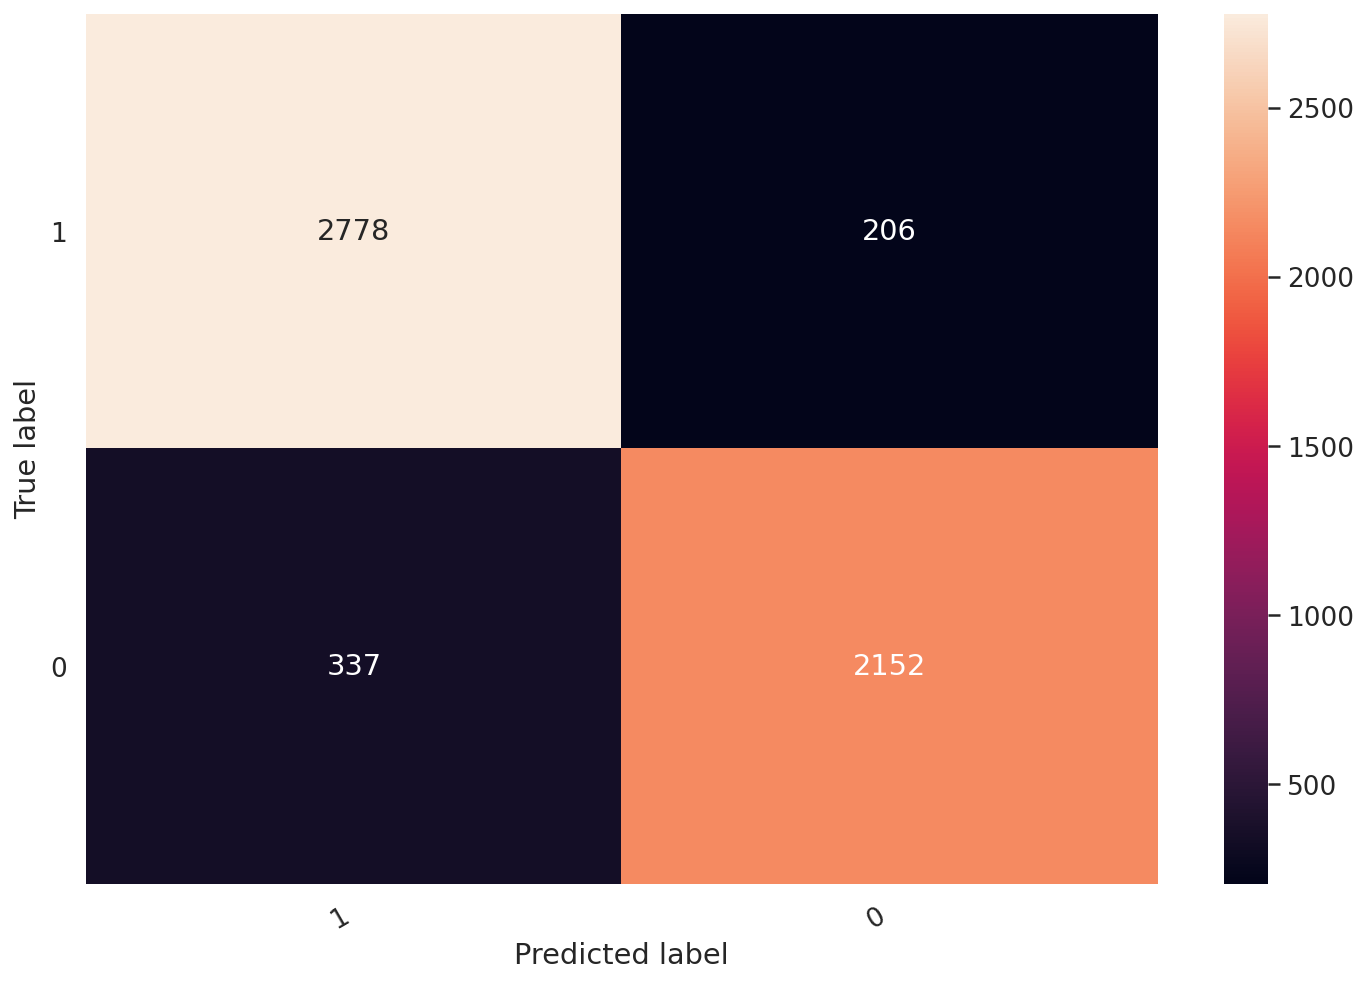

In [ ]:
matrix = sns.heatmap(confusion_matrix, annot=True, fmt="d")
matrix.yaxis.set_ticklabels(matrix.yaxis.get_ticklabels(), rotation=0, ha='right')
matrix.xaxis.set_ticklabels(matrix.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# **LOADING TRAINED MODEL**

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/BERT_FINAL/my_model')
new_model.summary()

In [ ]:
classes=['1', '0']
token = FullTokenizer(vocab_file="/content/drive/MyDrive/BERT/lightmodel/vocab.txt")

In [ ]:
sentences = [
  " Dude they dont finish enclosing the fucking showers. I hate half assed jobs. Whats the reasononing behind it? Makes no sense. ",
  " i am sry sir    "
]

preds = map(token.tokenize, sentences)
preds = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], preds)
pred_tokens = list(map(token.convert_tokens_to_ids, preds))

pred_tokens = map(lambda tids: tids +[0]*(128-len(tids)),pred_tokens)
pred_tokens = np.array(list(pred_tokens))

predictions = new_model.predict(pred_tokens).argmax(axis=-1)
hate=["HATE","NOT HATE"]

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label],"\nRESULT:",hate[label])
  print("")

In [ ]:
def predict(s):
  sentences=[s]
  preds = map(token.tokenize, sentences)
  preds = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], preds)
  pred_tokens = list(map(token.convert_tokens_to_ids, preds))

  pred_tokens = map(lambda tids: tids +[0]*(128-len(tids)),pred_tokens)
  pred_tokens = np.array(list(pred_tokens))

  predictions = new_model.predict(pred_tokens).argmax(axis=-1)
  
  

  for  label in  predictions:
      ans=classes[label]
  return ans
    
    
  